<a href="https://colab.research.google.com/github/yeongsunnnnn/2022-1-/blob/main/%EA%B8%B0%EB%A7%90_%EC%A0%95%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Audio processing -기말고사에 상당히 많이 다룰 내용일 것임.**

1. Fourier transform (분석용- 어떠한 주파수가 많은지 분석하는 것)

Spectogram
높은 음이 많은지, 낮은 음이 많은지 알려주는/ 어떠한 주파수 성분들이 있는지 입체적으로 알려주는 것
- 왼쪽으로 움직임
- x축은 시간, y축은 주파수
- 높은 주파수일수록 노란색, 빨간색
- spectrum을 time축으로 concatenate한 것
: concat of spectrum over time
- x축이 주파수이고 y축이 amplify라고 생각한다면 이 "한 장"을 time으로 여러 장들을 쭉 "연결시켜" 위에서 바라보았을 때의 형상을 나타낸 것이 spectogram임 

Spectrum
- 주어진 signal에 대해 어떤 주파수 성분이 많이 있나?를 알려줌
- given signal에 똑같은 길이의 a series of "complex phasors" with different frequencies를 "inner product"하여 그 결괏값들을 점으로 나타낸 것이 결과적으로 spectrum임
(inner product[같은 길이의 두 벡터에 있는 숫자들을 짝 별로 곱하고 그 값들을 모두 더하는 과정]를 하는 이유는 일종의 correlation을 보여주기 위하여, 즉 해당 frequency가 얼마나 있는지 probing/ sine phasor이 아닌 complex phasor을 쓰는 이유는 phase sensitivity 때문[일반적으로는 sine phasor을 inner product하긴함])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display

librosa는 audio processing package

# load / plot / play sound file

In [ ]:
# from google.colab import files
# fn = files.upload()
import os
url = "https://raw.githubusercontent.com/hsnam95/class2022Spring/main/aeiou.wav"
os.system("curl " + url + " > aeiou.wav")

s, sr = librosa.load('aeiou.wav')

- from google.colab import files
fn = files.upload()
이거를 통해서는 개별적으로 file upload를 통해 audio processing을 할 수 있음
- s는 signal을 뜻함(48600개의 숫자array가 1차원으로 존재), sr은 sampling rate을 뜻함(1초에 22050개의 숫자가 있음) => 2초 조금 넘겠다는 것을 추정할 수 있음

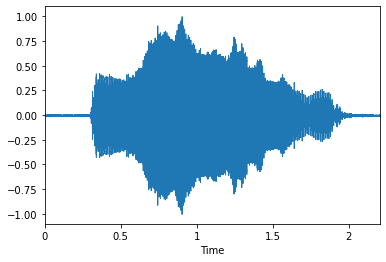

In [ ]:
s = librosa.util.normalize(s)
librosa.display.waveplot(s, sr)
ipd.Audio(s[7000:12000], rate=sr)

- librosa.display.waveplot(s, sr) 을 통해서 위와 같은 x축을 시간으로 한 plot을 볼 수 있음
- normalize를 통해 절댓값의 최댓값을 가지고 plot에 있는 모든 숫자를 나누기 하여 세로축이 -1과 1을 사이로 하도록 만들어주는 거임 
-s[7000:12000]은 7000번째부터 12000번째 까지의 sampling을 pick한 것 => 결과적으로 '아'만 나옴

#Fourier Transform for Spectrogram 

(0.0, 5000.0)

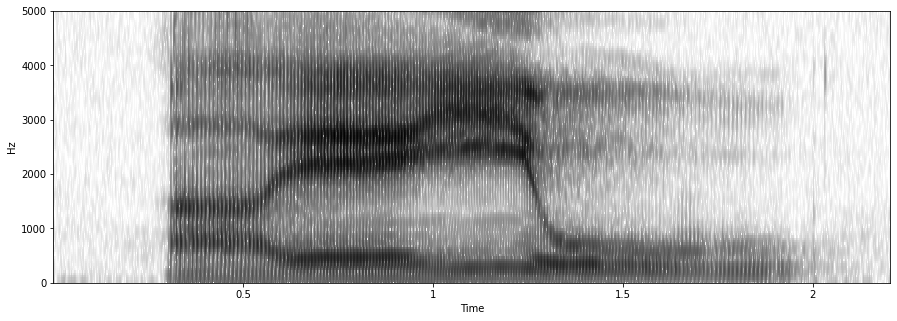

In [ ]:
s_preemp = librosa.effects.preemphasis(s)

n_fft=512
hop_length=int(0.001*sr)
win_length=int(sr*0.008)

spec = librosa.stft(s_preemp, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window = 'hann')
magspec = np.abs(spec)
dBspec = librosa.amplitude_to_db(magspec, ref=np.max)

plt.figure(figsize=(15, 5))
librosa.display.specshow(dBspec, sr=sr, x_coords = np.linspace(1, len(s), dBspec.shape[1])/sr , x_axis='time', y_axis='linear', cmap='Greys')
plt.ylim((0,5000))

- spectogram은 spectrum 한장씩(win_length만큼의 길이인[초단위]) 일정한 간격 (hop_length[초단위])으로 '겹치도록' 이동하면서 만든 것
- n_fft는 spectrum에 포함된 총 주파수의 갯수
-spec은 fourier transform을 해주는 과정 => 밑의 설명처럼 이 부분에서 복소수의 값이 나옴
- spectrum에서 given signal과 complex phasor이 inner product된 결괏값은 complex phasor의 영향으로 복소수 형태 (a+bi) => 이를 점으로 찍어주기 위해서는 numpy에 있는 abs가 해결해줌 (a, b)[실수부분, 허수부분]의 점을 찍어서 이 점과 원점 사이의 거리가 abs값임. 그리고 이 abs의 값(절댓값)을 실제 spectrum의 y축의 value로 나타내는 것임.
: magspec은 '복소수를 실수로' 만들어주는 과정
-  dBspec은 amplitude를 데시벨로 바꿔주는 과정 (거쳐가야 하는 과정)
- 그림 살펴보기 : 더 검은 부분이 우리 눈 쪽으로 솟아있고, 색이 얕은 부분은 우리 눈과 멀어지게 꺼져있다고 생각하면 됨. 입체적으로 생각하기.

2. Filter (변환용- 신호에 대해서 변형을 주는 것[함수를 통해 변환을 하는 것이 대부분이기 때문에 변환을 '함수'라고 부를 수도 있지만 그래도 이를 filter이라고 부름])
- x축이 time인 것을 time function(신호)
- 방법: weighted sum of signal's shifts (두가지 방법: FIR, IIR)

  * FIR: Y(k) = b<sub>1</sub>X(k) + b<sub>2</sub>X(k-1) + ... 
    - Y = H * X
         (H는 filter을 뜻함/ X(k)를 한 번 shift 시킨게 X(k-1))
  * IIR: a<sub>1</sub>Y(k) + a<sub>2</sub>Y(k-1) + ... = X(k)
    - Y = (1/H) * X 
    (FIR과 IIR의 filter은 서로 역함수 관계)
=> FIR과 IIR 모두 각각 b1, b2, b3...; a1, a2, a3...의 숫자값을 알면 쓸 수 있음 (이미 이 숫자 값은 용도에 따라 정해져 있음) / filter의 효과를 없애려면 b1;a1은 1로, b2, b3 ...; a1, a2, a3 ...는 모두 0으로 만들어주면 됨



# Filter for audio transformation

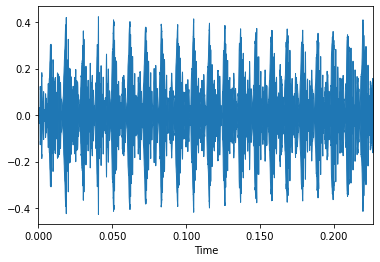

In [ ]:
from scipy.signal import lfilter
sig = s[7000:12000]
sig = lfilter(np.array([1]), np.array([1]), sig, axis=0)
librosa.display.waveplot(sig, sr)
ipd.Audio(sig, rate=sr)

- lfilter에는 (b, a, signal)넣으면 됨
(b와 a 값에는 그냥 숫자가 아닌 array로 만들어줘서 넣어야 됨)
ex. 위에 처럼 1로 넣으면 변화가 없음. 만약 a값에 1/2, 1/2, 1/2, 1/2를 넣으면 조금 더 완만하게 소리가 남. (filter값에 아무 값이나 넣으면 실행이 안되는 것도 포인트)


3. Auto correlation (자기자신[auto]과의 correaltion)
- f0(=pitch)값을 구하는 것
- y축은 correlation값(inner product한 결괏값), x축은 lag(signal을 복제한 것이 움직인 거리)할 때 => 완전히 겹쳐져 있을 때 y값이 가장 큼. 첫 peak와 두번째 peak 사이의 lag의 시간과 반복되는 패턴의 사이의 시간이 동일
- pitch의 값= 1/log peak 사이의 시간 길이

4. RMS: root mean square
- 진폭에 해당하는 두께를 represent하는 것
- signal에 있는 모든 값들을 제곱시키고 그것의 mean 값을 구한다. 그 다음 루트를 씌어준다.


# RMS(Root Mean Square) for intensity

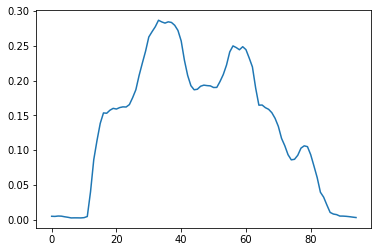

In [ ]:
rms = librosa.feature.rms(s)
plt.plot(rms[0])

# Autocorrelation for pitch(F0) measurement

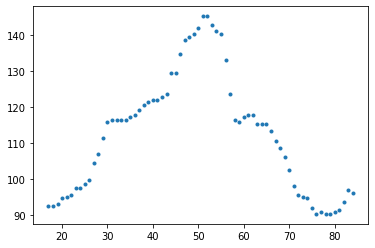

In [ ]:
F0, voiced_flag, voiced_prob = librosa.pyin(s, 60, 200)
plt.plot(F0, '.')

#Speech Processing
pulse train (=source), vocal tract (=filter)


source: 성대에서 만들어지는 소리(voice cords의 진동을 통해)
vocal tract: 구강. 입모양 자체 - filter 역할을 하는 것
x가 source가 되고, 이 source가 filter(구강)을 통해 특정 소리가 나타남

- 모음은 source와 filter로 이루어져 있으며, source는 다양한 주파수를 가지고 있는 phasors의 합임
- pulse train은 주파수가 같지만 다른 발음이라도, 모두 같음

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display

# Generate pulse train (=source at larynx)

ex. '아'라는 소리의 F0이 100hz라고 가정한다면, 최초의 phasor을 100hz의 sin곡선으로 정한 다음 200hz의 sin곡선, 300hz의 sin곡선 ... (2배, 3배, 4배 ... )쭉해서 이들을 더한 값이 source at larynx가 되는 것
=> 이를 통해 성대에서 나는 소리(pulse train = source)를 알 수 있음


In [ ]:
def phasor_sine(amp, sr, dur, freq, phase):
  t = np.arange(1, sr * dur+1)/sr
  theta = t * 2*np.pi * freq + phase
  s = amp * np.sin(theta)
  return s, t, theta

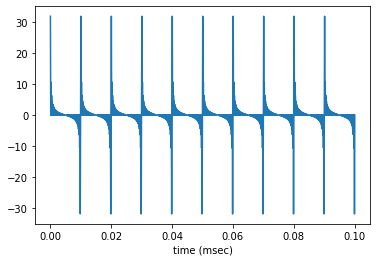

In [ ]:
amp = 1
sr = 10000
dur = 0.5

F0 = 100
Fend = int(sr/2)  

phase = 0

s_all = 0
for freq in range(F0, Fend+1, F0):
  s, t, theta = phasor_sine(amp, sr, dur, freq, phase)
  s_all += s

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t[0:1000], s_all[0:1000]); 
ax.set_xlabel('time (msec)')
ipd.Audio(s_all, rate=sr)

- for freq in range(F0, Fend+1, F0): F0인 100HZ부터 Fend+1인 5000HZ까지 100HZ 간격으로 frequency를 만들라는 뜻
- +=: 차곡차곡 더하라는 뜻
- s_all += s : 만든 signal들을 차곡차곡 합치라는 뜻 (0+100+200+300 ... +5000)





# Filtering source through vocal tract: Formants

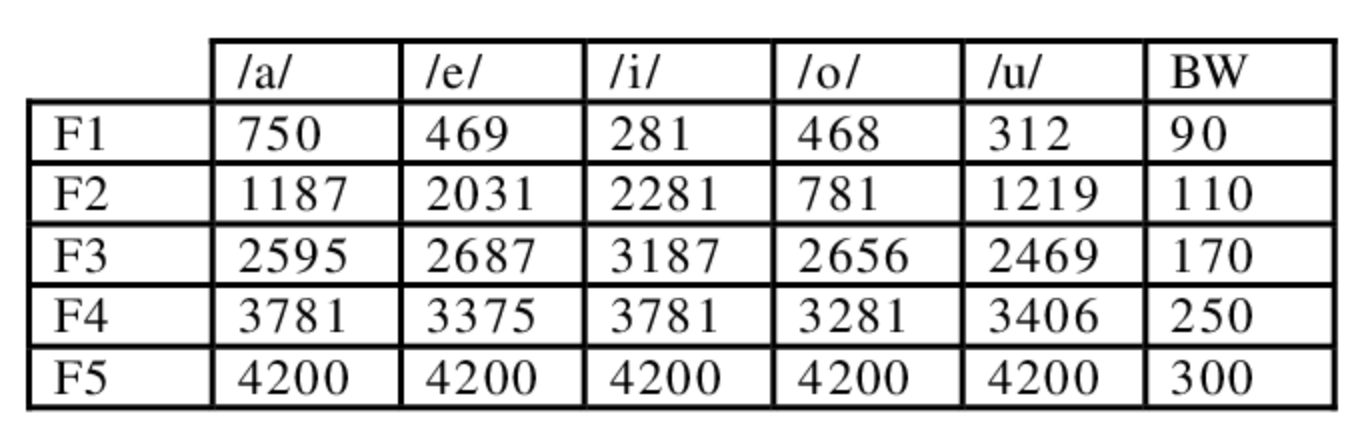

- F1, F2, F3 ...는 각 spectrum (x축은 frequency)의 peak 1, peak2, peak3 ...에 해당하는 frequency값
- filter도 하나의 spectrum이라는 거 명심
- source의 spectrum은 x축은 frequency이며 y축의 값은 모두 같은 형태 (공평한 크기)
- filter의 spectrum이 source의 spectrum과 만나면 filter의 spectrum과 source의 spectrum이 교차하는 부분의 밑의 y값들만 살아남게 됨
- BW=band width : spectrum에 나타나는 peak 부분의 넓이 -> BW가 크면 완만한 산이 되는 거임
 

In [ ]:
def resonance (srate, F, BW):
    a2 = np.exp(-hz2w(BW,srate))
    omega = F*2*np.pi/srate
    a1 = -2*np.sqrt(a2)*np.cos(omega)
    a = np.array([1, a1, a2])
    b = np.array([sum(a)])
    return a, b

- 특정한 Fn(ex. F1, F2 ...)의 filter a, b의 값을 알 수 있음

In [ ]:
def hz2w(F, sr):
    NyFreq = sr/2;
    w = F/NyFreq *np.pi;
    return w

In [ ]:
s = s_all

- 여기서 s_all은 pulse train

In [ ]:
from scipy.signal import lfilter

RG = 0  # RG is the frequency of the Glottal Resonator
BWG = 100  # BWG is the bandwidth of the Glottal Resonator
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

- spectrum을 비탈길로 만들었기 때문에 완만한 소리가 나옴

In [ ]:
RG = 750  # RG is the frequency of the 1st Formant
BWG = 90  # BWG is the bandwidth of the 1st Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
RG = 1187  # RG is the frequency of the 2nd Formant
BWG = 110  # BWG is the bandwidth of the 2nd Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
RG = 2595  # RG is the frequency of the 3rd Formant
BWG = 170  # BWG is the bandwidth of the 3rd Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
RG = 3781  # RG is the frequency of the 4th Formant
BWG = 250  # BWG is the bandwidth of the 4th Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
s = lfilter(np.array([1, -1]), np.array([1]), s)
ipd.Audio(s, rate=sr)

a는 [1]이니까 아무 효과도 없는 것이고, b는 [1, -1]을 통해 입술의 효과를 첨가함

# LPC filter coefficients

- 입력은 모음 signal
- 모음 분석에 이용 (Fourier은 모든 signal 분석에 이용 가능했음 ) => 모음의 filter의 spectrum을 볼 수 있고 이의 formant의 값들을 수학적으로 계산할 수 있음
-  H * Y = X (X는 pulse train)
=> signal Y(특정 모음)에 FIR 하면 pulse train X가 되는 H의 coefficients를 구하는 것임. 
즉, Y = 1/H * X 에서 H의 coefficients 구하는 것과 동일. 
X의 관점에서 lfilter의 a 계수값 추정하는 것임

In [ ]:
# from google.colab import files
# fn = files.upload()
import os
url = "https://raw.githubusercontent.com/hsnam95/class2022Spring/main/aeiou.wav"
os.system("curl " + url + " > aeiou.wav")

s, sr = librosa.load('aeiou.wav')
ipd.Audio(s[7000:12000], rate=sr)

In [ ]:
import scipy
M = int(sr/1000+4) # Number of LPC coefficnets
a = librosa.lpc(s[7000:12000], M)

M은 구해줄 cofficnets의 갯수

# Spectrum plotted from LPC coeffiencts

(0.0, 5000.0)

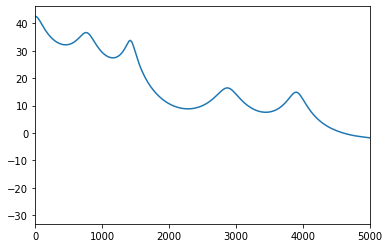

In [ ]:
w, h = scipy.signal.freqz(1, a)
plt.plot (w*sr/(2*np.pi), 20*np.log10(np.abs(h)))
plt.xlim((0,5000))


- x축이 frequency, y축은 데시벨 강도
- 위 plot은 '아' 모음의 filter 모양

# Formants & Bandwidths computed from LPC coefficients (for Grad students only)

In [ ]:
BWcutoff = 2000;
F = np.sort(np.angle(np.roots(a)))
order = np.argsort(np.angle(np.roots(a)))
F = F*sr/(2*np.pi);

BW = -2*np.log(abs(np.roots(a)))*sr/(2*np.pi);
BW = BW[order];

idx = [i for i in range(F.shape[0]) if (F[i] > 0) & (BW[i] < BWcutoff) ]

print(F[idx])
print(BW[idx])

[  773.0751  1427.4038  2873.7573  3904.3184  4630.678   5151.7295
  7404.265   7795.8794  8694.367   9274.946  10049.233 ]
[ 229.41571  130.27097  307.47186  229.12651 1215.9471   542.4114
  202.3538   303.34442 1630.4275   210.64189 1169.2583 ]


- peak에 해당하는 값(formant값)과 bandwith를 수학적으로 계산하여 정확히 나온 결괏값들

#Tokenization
- 단어 수준으로 끊는다.

In [ ]:
import nltk

- nltk = natural-language(text) tool kit

In [ ]:
# copy a file from github
import os
url = "https://raw.githubusercontent.com/hsnam95/class2022Spring/main/crime_punishment.txt"
os.system("curl " + url + " > crime_punishment.txt")

# read a text file in the server
file = open("crime_punishment.txt")
text = file.read().replace("\n", " ")
file.close()

- copy a file from github 부분을 통해 crime punishment text를 불러올 수 있음
- crime punishment.txt에 있는 모든 text들을 string의 형태로 'text'라는 변수에 가져온 것임

In [ ]:
# or copy/pase text here
text = 'Here’s to the crazy ones, the misfits, the rebels, the troublemakers, the round pegs in the square holes. \
The ones who see things differently — they’re not fond of rules. \
You can quote them, disagree with them, glorify or vilify them, \
but the only thing you can’t do is ignore them because they change things. \
They push the human race forward, and while some may see them as the crazy ones, we see genius, \
because the ones who are crazy enough to think that they can change the world, are the ones who do.'

In [ ]:
# write out a text file
file = open("tmp.txt", "w")
file.write(text)
file.close()

'tmp.txt'라는 이름으로 file 자체를 write out한 것임.

In [ ]:
text.split()

- 띄어쓰기를 기준으로 string을 'list'로 하나 하나 쪼갬.

In [ ]:
' '.join(text.split())

- space(''안에 있는 것이 space의 뜻임)를 가지고 list들을 결합하여라.

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
words = word_tokenize(text)

- 이렇게 하면 위의 방법과 달리 punctuation까지도 split할 수 있음
(nltk.download('punkt')의 덕분- punctuation의 의미를 알려줌)

In [ ]:
from nltk.tokenize import RegexpTokenizer
retokenize = RegexpTokenizer("[\w]+")
words = retokenize.tokenize(text)

- 위와 달리 punctuation들이 아예 빠져 있게 됨.

In [ ]:
words

#Normalization

- stemming : 어간 추출 - 대충의 패턴 규칙으로 어미를 잘라내는 것(임의로 패턴 규칙을 설정하였기 때문에 사전에는 없는 어간이 나올 수도 있음)
- Lemmatization : 표제어를 추출하여 원형으로 복귀해주는 것

**1. stemming**
- 2가지 방법

In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
[stemmer.stem(w) for w in words]

In [ ]:
from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()
[stemmer.stem(w) for w in words]

**2. lemmatization**

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
[lemmatizer.lemmatize(w) for w in words]

#Stopword

- 조동사, 대명사, 관사 등 자주 나오는 것들
- 원래는 nltk에서 stopwords가 정해져 있음

In [ ]:
from nltk.corpus import stopwords  
nltk.download('stopwords')
print(words)
words = [w for w in words if not w in stopwords.words('english')]
print(words)

- words = [w for w in words if not w in stopwords.words('english')] : stopwords에 해당되는 word들은 그냥 빼고 그 외의 것들을 words에 포함시키라는 의미

#Collocation, Concordance

In [ ]:
nltk.download('gutenberg')
text = nltk.corpus.gutenberg.raw('austen-emma.txt')
words = retokenize.tokenize(text)

- nltk.download('gutenberg') : nltk라는 package속에 담겨 gutenberg를 불러온 것임
- text = nltk.corpus.gutenberg.raw('austen-emma.txt') : 그 중 austen의 emma라는 text 불러온 것임
- text의 type은 string
- text의 length은 887071
- words의 type은 list

In [ ]:
nltk.Text(words).collocations()  # default값: (num=20, window_size=2)->20개의 collocations, 2개가 연속으로 나오는 단어들

In [ ]:
nltk.Text(words).concordance('Emma', 79, 10)

- Emma라는 단어가 등장하는 앞 뒤로의 context들 총 10개를 뽑아라 ; 79의 의미는 character들의 갯수들이 총 79개 

In [ ]:
nltk.Text(words).dispersion_plot(["Emma", "Knightley", "Frank", "Jane", "Harriet", "Robert"])

- "Emma", ""....의 단어들이 어떻게 분포되어 있는지를 plot으로 나타내 준 것

In [ ]:
# Distributional similarity: 
# find other words which appear in the same contexts as the specified word; 
# list most similar words first.
nltk.Text(words).similar("Emma")

- Emma와 비슷하게 양쪽 옆으로 나올 단어들을 찾아보아라. 가장 비슷한 것부터 나열해보아라.

In [ ]:
# Find contexts where the specified words appear; list most frequent common contexts first.
nltk.Text(words).common_contexts(["Emma", "she"])

- 2개의 단어들 양쪽 옆으로 나올 단어들을 찾아보아라
-  _는 그 곳에서 2개의 단어들이 들어가 있다는 의미
- 이것도 마찬가지로 가장 많이 나오는 순서대로 나열되고 있음

#Frequency distribution, Frequency plot

In [ ]:
fd = nltk.FreqDist(words).most_common(20)
fd

- 어떤 단어들이 가장 많이 나오는지 20개를 선별하여 가장 많이 나오는 순서부터 나열하여라

In [ ]:
nltk.Text(words).plot(20)

- 위와 똑같은 정보를 plotting 해서 나타낸 것

#Dictionary

In [ ]:
nltk.download('words')
nltk.corpus.words.words('en')[-20:-1]

- 영어 dictionary 불러온 다음 dictionary에서 제일 마지막 20개를 찾아보라는 의미

In [ ]:
len(nltk.corpus.words.words('en'))

- dictionary가 포함하고 있는 단어 갯수

#Extract information (pos tag, named entitiy)

**1. pos tag : part of speech tag**

CC	coordinating conjunction \
CD	cardinal digit \
DT	determiner \
EX	existential there (like: "there is" ... think of it like "there exists") \
FW	foreign word \
IN	preposition/subordinating conjunction \
JJ	adjective	'big' \
JJR	adjective, comparative	'bigger' \
JJS	adjective, superlative	'biggest' \
LS	list marker	1) \
MD	modal	could, will \
NN	noun, singular 'desk' \
NNS	noun plural	'desks' \
NNP	proper noun, singular	'Harrison' \
NNPS	proper noun, plural	'Americans' \
PDT	predeterminer	'all the kids' \
POS	possessive ending	parent's \
PRP	personal pronoun	I, he, she \
PRP\$	possessive pronoun	my, his, hers \
RB	adverb	very, silently, \
RBR	adverb, comparative	better \
RBS	adverb, superlative	best \
RP	particle	give up \
TO	to	go 'to' the store. \
UH	interjection	errrrrrrrm \
VB	verb, base form	take \
VBD	verb, past tense	took \
VBG	verb, gerund/present participle	taking \
VBN	verb, past participle	taken \
VBP	verb, sing. present, non-3d	take \
VBZ	verb, 3rd person sing. present	takes \
WDT	wh-determiner	which \
WP	wh-pronoun	who, what \
WP\$	possessive wh-pronoun	whose \
WRB	wh-abverb	where, when \

In [ ]:
sent = "I am Jhon from America and would like to go to Starbuck"
words = nltk.word_tokenize(sent)

In [ ]:
nltk.download('averaged_perceptron_tagger')
pos = nltk.pos_tag(words)

**2. named entity : 특정한 분류 기준을 통해 분류하는 것**



In [ ]:
nltk.download('maxent_ne_chunker')
NE = nltk.ne_chunk(pos)
# common Entity types: ORGANIZATION, PERSON, LOCATION, DATE, TIME, MONEY, and GPE (geo-political entity)

#Wordcloud

- frequency를 기반으로 하며 font size와 관련이 되어 있음

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = nltk.corpus.gutenberg.raw('bible-kjv.txt')

wc = WordCloud().generate(text) 
plt.imshow(wc)

- text는 string으로 담겨 있음
- 많이 나오는 단어들부터 font size가 달라지면서 image로 나타나짐

In [ ]:
stopwords = set(STOPWORDS) 
stopwords.add('unto')
wc = WordCloud(stopwords = stopwords).generate(text) 
plt.imshow(wc)

- stopwords.add('unto') : 정해진 stopwords 중에서 unto를 더한 것임
- wc = WordCloud(stopwords = stopwords).generate(text) : 위에 있는 wordcloud와는 조금 달리, 기존의 stopwords에서 바로 위에서 설정한 stopwords으로 define하여 generate한 것
-> unto를 포함한 stopwords가 image에서 빠지게 됨

#Regular expression

In [ ]:
import re

- re에서 가장 중요한 function 3개: search, findall, sub

In [ ]:
re.search('a', 'abcdefa')

- 'abcdefa'에서 'a'를 찾아라 -> a가 두 개 있지만, 이 function에서는 제일 첫번째의 a만 불러옴
- span과 match

In [ ]:
re.findall('a', 'abcdefa')

- search와 달리, 모두 찾아주는 것
- 찾아서 list로 만들어줌
- 'abcdefa'에서 'a' 모두 찾기 때문에 ['a','a']라는 결괏값이 나옴

In [ ]:
re.sub('a', 'b', 'abcdefa')

- a를 b로 바꾸어라 (모든 a를 b로 바꾸는 것임)

#1. search

In [ ]:
'''       Basic Regular Expression Meta-Characters, Including Wildcards, Ranges and Closures

.	        Wildcard, matches any character
^abc	    Matches some pattern abc at the start of a string
abc$	    Matches some pattern abc at the end of a string
[abc]	    Matches one of a set of characters
[^abc]    Matches anything but a set of characters
[A-Z0-9]	Matches one of a range of characters
ed|ing|s	Matches one of the specified strings (disjunction)
*	        Zero or more of previous item, e.g. a*, [a-z]* (also known as Kleene Closure)
+	        One or more of previous item, e.g. a+, [a-z]+
?	        Zero or one of the previous item (i.e. optional), e.g. a?, [a-z]?
{n}	      Exactly n repeats where n is a non-negative integer
{n,}	    At least n repeats
{,n}	    No more than n repeats
{m,n}	    At least m and no more than n repeats
a(b|c)+	  Parentheses that indicate the scope of the operators
(...)     Matches whatever regular expression is inside the parentheses
\d
Matches any decimal digit; this is equivalent to the class [0-9].
\D
Matches any non-digit character; this is equivalent to the class [^0-9].
\s
Matches any whitespace character; this is equivalent to the class [ \t\n\r\f\v].
\S
Matches any non-whitespace character; this is equivalent to the class [^ \t\n\r\f\v].
\w
Matches any alphanumeric character; this is equivalent to the class [a-zA-Z0-9_].
\W
Matches any non-alphanumeric character; this is equivalent to the class [^a-zA-Z0-9_].

'''

In [ ]:
import nltk
nltk.download('words')
engdict = nltk.corpus.words.words('en')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


- 일단 english dictionary 불러오기
- engdict의 type은 list
**- search와 findall은 list가 아닌 string에 적용이 되는 것임**

In [ ]:
result = [w for w in engdict if re.search('ed$', w)]
# result = [w for w in engdict if re.search('^..j..t..$', w)] ->j앞에 2개의 스펠링, t앞에 2개의 스펠링, 그리고 t뒤에 2개의 스펠링으로 끝나는 단어 찾기
# result = [w for w in engdict if re.search('^[ghi][mno][jlk][def]$', w)] ->[ghi]는 g, h, i 중에 하나라는 뜻. 총 4개의 스펠링으로 이루어진 단어 찾기
# result = [w for w in engdict if re.search('^[ah]+$', w)][:10] -> a혹은 h가 앞에 한번 이상 나오는 단어들을 찾아라, 그리고 그 단어들 중 10개를 찾아라
print(result[:10])

['abaissed', 'abandoned', 'abased', 'abashed', 'abatised', 'abed', 'aborted', 'abridged', 'abscessed', 'absconded']


- for w in engdict : engdict(type은 list)에 있는 각각의 item들(type은 string)을 w로 받으라는 의미
- 그리고 if re.search('ed$', w) 를 하게 되는데, 이것은 받은 w라는 string에서 ed$가 들어있는 string들을 search 하여 맨 앞에 있는 w로 listing하라는 뜻
=> 결과적으로 w에는 ed가 끝에 포함된 단어들만 존재하게 됨
- ed$의 의미 : string의 끝에서 ed가 있다 (위에 있는 regular expression 리스트 참고)
- 만약 re.search('ed$, 'wanted')라면 이 결괏값은 span=(4,6), match: ed 인 것(wanted끝에 ed가 있으니까)


In [ ]:
import re
import nltk
nltk.download('treebank')
wsj = nltk.corpus.treebank.words()
#또 다른 text 찾은 거임

result = [w for w in wsj if re.search('(ed|ing)$', w)] 
#-> ed 혹은 ing로 끝나는 단어들 찾기
# result = [w for w in wsj if re.search('^[0-9]+\.[0-9]+$', w)] -> 처음에 0에서 9까지의 숫자들 중 하나 이상 쓰여지고 그다음 쩜(\또는/의 반대 슬래쉬 다음에 적어서 실제 기호라는 걸 나타냄) 나오고 그다음 다시 0에서 9까지의 숫자들 중 하나 이상이 끝으로 온다
# result = [w for w in wsj if re.search('^[A-Z]+\$$', w)]
# result = [w for w in wsj if re.search('^[0-9]{4}$', w)] -> 0에서 9까지의 숫자들이 총 4번 나와라
# result = [w for w in wsj if re.search('^[0-9]+-[a-z]{3,5}$', w)]
# result = [w for w in wsj if re.search('^[a-z]{5,}-[a-z]{2,3}-[a-z]{,6}$', w)]

result = sorted(set(result))
print(result[:10])

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
['62%-owned', 'Absorbed', 'According', 'Adopting', 'Advanced', 'Advancing', 'Alfred', 'Allied', 'Annualized', 'Anything']


- result = sorted(set(result)) : 이를 통해서 결괏값이 sort가 되어 나타남

#2. findall

In [ ]:
import os
url = "https://raw.githubusercontent.com/hsnam95/my/main/friends_season01_script.txt"
os.system("curl " + url + " > friends_season01_script.txt")

# read a text file in the server ->변수로 불러오는 작업
file = open("friends_season01_script.txt")
text = file.read()
file.close()
text

'101. The One Where Monica Gets a New Roommate\n(The Pilot-The Uncut Version)\n\nWritten by: Marta Kauffman & David Crane\nTranscribed by: guineapig\nAdditional transcribing by: Eric Aasen\n(Note: The previously unseen parts of this episode are shown in blue text.)\n\n[Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.]\nMonica: There\'s nothing to tell! He\'s just some guy I work with!\nJoey: C\'mon, you\'re going out with the guy! There\'s gotta be something wrong with him!\nChandler: All right Joey, be nice.Ê So does he have a hump? A hump and a hairpiece?\nPhoebe: Wait, does he eat chalk?\n(They all stare, bemused.)\nPhoebe: Just, \'cause, I don\'t want her to go through what I went through with Carl- oh!\nMonica: Okay, everybody relax. This is not even a date. It\'s just two people going out to dinner and- not having sex.\nChandler: Sounds like a date to me.\n[Time Lapse]\nChandler: Alright, so I\'m back in high school, I\'m standing in the middle of the cafeteria,

- text의 type은 string

In [ ]:
pattern = '(?<=: ).+(?=[\.|\?|\!])'
sent = re.findall(pattern, text)
sent
text = '\n'.join(sent)
text

'I saw your twenty-five, and I raise you.'

- (?<=: ).+(?=[\.|\?|\!]) 
=> ?<=: 다음에 오는 것은 앞에 나와야 하는 조건, ?= 다음에 오는 것은 뒤에 나와야 하는 조건 두 괄호들 사이에 오는 쩜들은 캐릭터들(찾아지는 결괏값이지)
- 따라서.. 저 위를 해석해보자
=> :과 스페이스 다음에 오면서 ., ?, ! 중에 하나가 끝에 오는 하나 이상의 캐릭터를 찾아라
- 지금 \<-이게 원래 역슬래쉬인데 이렇게 나옴.. 어쨌든 역슬래쉬 다음에 n이 나오면 이는 '엔터'의 의미 
=> 줄바꿈을 이용하여 다시 sent된 것들을 결합해줌

In [ ]:
# write out a text file
file = open("tmp.txt", "w")
file.write(text)
file.close()

- 이를 통해 text 다운로드 가능

#**인공지능**

- 데이터의 종류 : 영상, 소리, 텍스트
- 입력과 출력이 같을 수 있음
- 데이터는 인공지능으로 들어갈 때...
=> 영상 데이터는 확대하여 그림 그 자체를 통해, 소리 데이터는 확대하여 점들을 통해, 텍스트도 비슷하게 하여 모두 '긴 숫자들로 표현한다.' 즉, 데이터는 "숫자열"이다!
- ai는 직사각형의 형태의 숫자들로 이루어져 있는 것임
- 입력데이터 숫자열은 각각의 ai 숫자열들과 곱해진 다음 더해져서 출력데이터 숫자열을 만드는 것임
- 따라서 입력데이터 숫자열과 출력데이터 숫자열은 각각 벡터라고 하고, 인공지능의 숫자열들은 행렬(직사각형 모양으로 벡터들이 모아진 것)이라고 함
- 벡터는 한줄짜리 행렬이라고 볼 수 있음 
- ai의 행렬은 2개 이상이 될 수 있음 : 각 행렬들이 순서대로 곱해져서 출력데이터가 만들어짐 => 행렬이 2개 이상이 되니까 벡터와 벡터 사이의 거리가 더 딥해졌음. 그래서 우리는 이러한 애들을 "딥러닝"이라고 부르는 것임!
-1940년대부터 2000년대까지는 ai의 행렬의 개수가 아주 많아도 3개밖에 안되었음. 그래서 딥러닝 이라는 이름을 붙이진 않았음. 인터넷 발달로 데이터가 많아지면서, deep한 structure이 필요했고 하드웨어의 발전으로 그래픽 카드가 나타나게 되면서 ai의 행렬의 갯수들이 비교적 많아짐.
- 화면의 픽셀 자체들이 모두 다 행렬임.다음 화면으로 넘어가기 위해서는 행렬 계산이 필요함. 
-GPU가 발달하면서 그리고 인터넷이 발달하면서 AI의 시대가 도래함.
- x->y 일 때, 화살표에는 하나의 숫자가 배정되어 있는 것임. 만약 화살표에 있는 숫자가 a라고 할 때, 우리는 식 y=ax로 나타낼 수 있음
- 입력값을 2개, 예를 들어서 x와 1로 설정하면 화살표는 두개가 생김. 그리고 그 두 개의 화살표에 각각 a와 b라는 숫자가 있다고 생각한다면 이는 y=ax+b의 식으로 나타낼 수 있음. 이것이 바로 "인공지능의 기본단위"!!!!!!
-사실상 화살표가 ai의 행렬, 즉 ai임
-행렬을 만들기 위해 많은 빅데이터를 수집하는 과정을 우리는 "훈련" 혹은 "학습"이라고 함
-딥러닝은 사실상 행렬을 학습하는 것
-epoch
-입력과 출력 사이에 중간 벡터를 더할 수 있다 (딥러닝이니까 당연한 말이겠지...)

**요약
-인공지능의 대표선수는 인 공 신 경 망
-인공지능은 어떤 입력을 출력으로 예측하는 함수
-입력과 출력은 벡터, 함수는 행렬
-데이터만 있으면 행렬을 추저해낼 수 있고, 이 행렬 자체가 인공신경망

- hugging face 에서 multimodal이 난이도 있는 부분이어서 대기업들이 많이 시도함
-지금은 GPT 3까지 나옴
- GPT 2는 뭐였냐면.. 조금의 문장만 쓰면 그걸 완전한 문장으로 output으로 나타내주는 것이었음

#huggingface
- 각 model들에 대한 내용 웹사이트 들어가서 어느정도 숙지하기

- gr.Interface.load("로드 하고 싶은 것의 제목").launch()가 되는 것도 있고, 안되는 것도 있음 -> 안되는 것은 하나하나 직접 해야됨-> 우리가 gradio화로 만들기!

for example...

In [5]:
!pip install gradio
import gradio as gr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.1 MB 30.7 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 256 kB 61.1 MB/s 
     |████████████████████████████████| 212 kB 63.5 MB/s 
     |████████████████████████████████| 1.1 MB 65.8 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 2.0 MB 46.3 MB/s 
     |████████████████████████████████| 144 kB 45.3 MB/s 
     |████████████████████████████████| 271 kB 62.4 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 11.1 MB 60.0 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 80 kB 10.6 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 4.0

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes -> 1000개의 정보 중 확률이 제일 큰 하나를 model이 예측하는 것
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

- url을 통해 image를 구축하였는데 이 image는 숫자 형태들로 저장되어 있을 것임
- 여기서 feature은 사진에 대한 정보, 참고로 색깔들은 모두 숫자로 나타나져 있는 것임
- 사실상 입력되는 것은 url이 아니라 image임!

Demo in gradio

In [3]:
def func (image):
  feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
  model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

  inputs = feature_extractor(images=image, return_tensors="pt")
  outputs = model(**inputs)
  logits = outputs.logits
  # model predicts one of the 1000 ImageNet classes
  predicted_class_idx = logits.argmax(-1).item()
  predicted_class = model.config.id2label[predicted_class_idx]
  return predicted_class

- function으로 만들어 준 것
- image가 입력값, predicted class-text가 출력값

In [6]:
gr.Interface(fn=func, inputs='image', outputs='text').launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://27883.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7f747b8b8b90>,
 'http://127.0.0.1:7860/',
 'https://27883.gradio.app')

Exception in callback None(<Task finishe...> result=None>)
handle: <Handle>
Traceback (most recent call last):
  File "/usr/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
TypeError: 'NoneType' object is not callable


- gradio로 만들어준 것

- 이미지 다운 일일이 받아서 gradio 실행하기 귀찮을 때에는... 밑에처럼 하면 된다

In [1]:
import os
url = "https://raw.githubusercontent.com/hsnam95/class2022Spring/main/tiger.jpg"
os.system("curl " + url + " > tiger.jpg")
url = "https://raw.githubusercontent.com/hsnam95/class2022Spring/main/dog.jpg"
os.system("curl " + url + " > dog.jpg")

0

In [7]:
gr.Interface(fn=func, inputs='image', outputs='text', examples = ['tiger.jpg', 'dog.jpg']).launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://52509.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7f7478f46190>,
 'http://127.0.0.1:7861/',
 'https://52509.gradio.app')

Exception in callback None(<Task finishe...> result=None>)
handle: <Handle>
Traceback (most recent call last):
  File "/usr/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
TypeError: 'NoneType' object is not callable


#Image classification

for example...

In [ ]:
!pip install transformers

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Demo in gradio

In [ ]:
def func (image):
  feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
  model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

  inputs = feature_extractor(images=image, return_tensors="pt")
  outputs = model(**inputs)
  logits = outputs.logits
  # model predicts one of the 1000 ImageNet classes
  predicted_class_idx = logits.argmax(-1).item()
  predicted_class = model.config.id2label[predicted_class_idx]
  return predicted_class

In [ ]:
import os
url = "https://raw.githubusercontent.com/hsnam95/class2022Spring/main/tiger.jpg"
os.system("curl " + url + " > tiger.jpg")
url = "https://raw.githubusercontent.com/hsnam95/class2022Spring/main/dog.jpg"
os.system("curl " + url + " > dog.jpg")

In [ ]:
gr.Interface(fn=func, inputs='image', outputs='text', examples = ['tiger.jpg', 'dog.j

#Fill-Mask

for example...

In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-uncased')
unmasker("Hello I'm a [MASK] model.")

Demo in gradio

In [ ]:
import pandas as pd
def func (text):
  unmasker = pipeline('fill-mask', model='bert-base-uncased')
  result = unmasker(text)
  df = pd.DataFrame(result)
  return df

In [ ]:
examples = ["Hello I'm a [MASK] model.", "It is raining outside. I feel [MASK]."]

In [ ]:
gr.Interface(fn=func, inputs='text', outputs='dataframe', examples = examples).launch()

#Token classification

- natural language understanding: natural language가 주어져 있다면, 이에 대해 필요한 정보들만 뽑아내는 것
- NER이 대표적임
- recognize four types of entities: location (LOC), organizations (ORG), person (PER) and Miscellaneous (MISC)

for example... (NER)

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "My name is Wolfgang and I live in Berlin"

ner_results = nlp(example)
print(ner_results)

- 여기선 nlp가 모델인 것임

Demo in gradio

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
def func (text):
  tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
  model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
  nlp = pipeline("ner", model=model, tokenizer=tokenizer)
  result = nlp(text)
  df = pd.DataFrame(result)
  return df

In [ ]:
examples = ["My name is Wolfgang and I live in Berlin", "I will visit Seoul to see Chris"]

In [ ]:
gr.Interface(fn=func, inputs='text', outputs='dataframe', examples = examples).launch()

#Sentence similarity

- two texts 사이에... 이때 text가 sentence 이던, paragragh 이던 상관 없음
- 이 model에서는 input texts를 vectors(embeddings)로 한번 바꿔주어야 두 text간의 similarity를 비교할 수 있음

for example...

In [ ]:
!pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer, util
sentences = ["This is an example sentence", "it is one example writing"]

model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(sentences)
print(embeddings)

In [ ]:
len(embeddings[1])

- 위는 embeddings(sentences를 숫자로 나타냄)에서 2번째 list의 length를 구하는 것
- 각도가 0도이면 유사도가 가장 높고, 90도이면 가장 낮은 것 -> cosx의 x값에 넣어주면 0도는 1, 90도는 0의 결괏값이 나옴
- similarity between two vecters는 그 벡터들의 각도값의 코사인 벡터로 하면 됨 = cosine similarity

In [ ]:
cosine_scores = util.pytorch_cos_sim(embeddings[0], embeddings[1])
cosine_scores

Demo in gradio

In [ ]:
def func (text1, text2):
  from sentence_transformers import SentenceTransformer, util
  model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
  embeddings = model.encode([text1, text2])
  cosine_scores = util.pytorch_cos_sim(embeddings[0], embeddings[1])
  return cosine_scores

In [ ]:
examples = [["This is an example sentence", "it is one example writing"], ["A frog is hopping near the pond", "I love Korean Food"]]

In [ ]:
gr.Interface(fn=func, inputs=['text', 'text'], outputs='number', examples = examples).launch()

#Huggingface pipelines

- 아주 간단한 함수임
- input과 output만 보이면 됨
- model의 files and versions에 들어가서 config.json을 클릭하여 충분히 많은 줄들이 존재하면 pipelines를 쓸 수 있는 것임
- task 중 특정한 model을 우리가 정하지 않는다면, 정해져있는 디폴트 값의 model이 적용됨

In [2]:
!pip install transformers
from transformers import pipeline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 31.8 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 6.6 MB 45.9 MB/s 
     |████████████████████████████████| 596 kB 42.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pipe = pipeline(task="audio-classification")

- 이 task 중에서 특정한 model을 사용하고 싶으면, 괄호에 model="model의 이름"을 넣으면 됨

In [ ]:
pipe("go.wav")

- wav를 업로드하여 실행시키면, 해당 음성으로 추정되는 단어들을 확률 별로 제시해줌

In [ ]:
pipe = pipeline(task="automatic-speech-recognition")

- 이 task도 위의 task와 동일한 작용방식을 가짐

In [ ]:
pipe = pipeline(task="conversational")

In [ ]:
from transformers import Conversation

conversation_1 = Conversation("Going to the movies tonight - any suggestions?")
conversation_2 = Conversation("What's the last book you have read?")
pipe([conversation_1, conversation_2])

In [ ]:
conversation_1.add_user_input("Is it an action movie?")
conversation_2.add_user_input("What is the genre of this book?")
pipe([conversation_1, conversation_2])

- 위는 bot이 대답한 결괏값에 대한 추가 질문을 한 것임

In [ ]:
pipe = pipeline(task="feature-extraction")

In [ ]:
pipe("What's the last book you have read?")

In [ ]:
pipe = pipeline(task="fill-mask")

In [ ]:
pipe("The goal of life is <mask>.")

In [ ]:
pipe = pipeline(task="image-classification")

In [ ]:
pipe = pipeline(task="image-segmentation")

In [ ]:
pipe = pipeline(task="ner")

In [ ]:
pipe = pipeline(task="object-detection")

In [ ]:
pipe = pipeline(task="question-answering")

In [ ]:
pipe = pipeline(task="sentiment-analysis")

In [ ]:
pipe = pipeline(task="summarization")

In [ ]:
import torch
print(torch.__version__)
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# maybe need to restart runtime
pipe = pipeline(task="table-question-answering")

In [ ]:
data = {
    "actors": ["brad pitt", "leonardo di caprio", "george clooney"],
    "age": ["56", "45", "59"],
    "number of movies": ["87", "53", "69"],
    "date of birth": ["7 february 1967", "10 june 1996", "28 november 1967"],
}
pipe(data, 'how old is brad pitt?')

In [ ]:
pipe = pipeline(task="text-classification")

In [ ]:
pipe = pipeline(task="text-generation")

In [ ]:
pipe = pipeline(task="text2text-generation")

In [ ]:
pipe = pipeline(task="token-classification")

In [ ]:
pipe = pipeline(task="translation_en_to_de")

- en to de는 english to germany

In [ ]:
pipe = pipeline(task="zero-shot-classification")

- zero shot은 아무것도 가르치지 않았다는 뜻

In [ ]:
pipe("one day I will see the world", ['travel', 'cooking', 'dancing'])

- ['travel', 'cooking', 'dancing'] : 이 셋 중 무엇인지 확률적으로 맞추어보아라

In [3]:
pipe = pipeline(task="zero-shot-image-classification")

No model was supplied, defaulted to openai/clip-vit-base-patch32 (https://huggingface.co/openai/clip-vit-base-patch32)


Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/577M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/842k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [4]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
pipe(url, candidate_labels=["a photo of a cat", "a photo of a dog"])

[{'label': 'a photo of a cat', 'score': 0.9974083304405212},
 {'label': 'a photo of a dog', 'score': 0.002591644646599889}]

#tensorflow hub 와 pytorch hub 
- 원래는 model의 저장소가 아닌 ai model을 만들 때 편리하게 사용할 수 있는 python package 였으나, 현재는 hugging face와 같이 model이 저장된 공간으로도 활용됨
(두개 모두 각각 python으로 쓰여져 있는 ai의 packages 중 하나임. aimodel들은 대부분 tf나 torch를 통해 만들어짐)
- tensorflow hub (google) : 속도를 더 빨리 하는데 도움이 됨. tensorflow light같은 것으로. 핸드폰에 적용 가능
- pytorch hub (facebook) : 연구자들이 많이 씀
- huggingface에 aimodel들이 많이 있지만, tf와 torch에도 있음


# Tensorflow Hub

#image classification (e.g. inception_v3)

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub

In [ ]:
model = hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/classification/5")

In [1]:
from PIL import Image
import requests
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
import numpy as np
image = np.array(image)
# reshape into shape [batch_size, height, width, num_channels]
image = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
# Use `convert_image_dtype` to convert to floats in the [0,1] range.
image = tf.image.convert_image_dtype(image, tf.float32)

- 원래 image는 3차원인데, tf.reshape를 통해 4차원으로 바꿈
- 그 다음, 원래 range를 0에서 1까지로 바꿔줌

In [ ]:
logits = model(image)
np.argmax(logits)

- np.argmax(logits)를 통해 출력한 logits중 가장  큰 확률을 가진 것의 순서를 찾아보는 거임

https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt 

#Pytorch Hub

#image generation (e.g. PGAN)

In [ ]:
import torch
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub', 'PGAN', model_name='celebAHQ-512', pretrained=True)

In [ ]:
num_images = 4
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)

# let's plot these images using torchvision and matplotlib
import matplotlib.pyplot as plt
import torchvision
grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

- noise를 넣어주는 이유: noise는 랜덤의 숫자인 것이고 이 숫자들이 output(존재하지 않는 celebrity's image)을 만들어내는 것임 

#Data repositories - kaggle, AI hub

- kaggle : train에 있는 data들을 통해 행렬(model)을 만드는 것이고, val에 있는 data들을 통해 train을 하는 과정에서 잘 되고 있는 확인하고, test에 있는 data들은 직접 써보는 것임
- time series : 입력이 time인 모든 data들을 일컫는 말

- ai hub : 한국 data들이 있돠